In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import os.path as osp

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances


In [3]:
WORKING_DIR = '/home/ntphat/projects/medico/medico'
os.chdir(WORKING_DIR)

DATA_DIR = 'data'
coco_annot = osp.join(DATA_DIR, 'coco_annotation.json')

register_coco_instances("polyp_train", {}, coco_annot, "data/images")

In [6]:
polyp_metadata = MetadataCatalog.get('polyp_train')
polyp_dataset = DatasetCatalog.get('polyp_train')

WARNING [10/02 16:14:48 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/02 16:14:48 d2.data.datasets.coco]: Loaded 1000 images in COCO format from data/coco_annotation.json


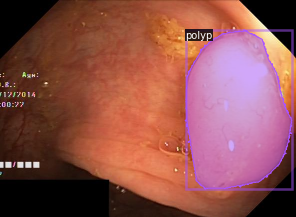

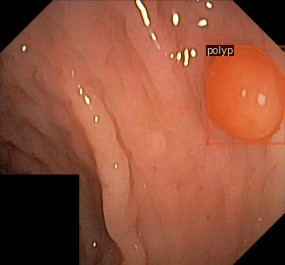

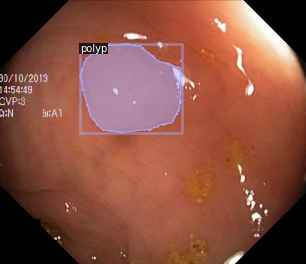

In [19]:
import matplotlib.pyplot as plt
from PIL import Image


for d in random.sample(polyp_dataset, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=polyp_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv_img = out.get_image()[:, :, ::-1]
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(cv_img))
#     plt.imshow(cv_img)
    

## DEFINE MODEL

In [21]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("polyp_train",)
cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)
cfg.OUTPUT_DIR = 'result/maskrcnn'

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[10/02 16:29:03 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[10/02 16:29:04 d2.engine.train_loop]: Starting training from iteration 0
[10/02 16:29:09 d2.utils.events]:  eta: 0:01:01  iter: 19  total_loss: 2.428  loss_cls: 0.733  loss_box_reg: 0.989  loss_mask: 0.688  loss_rpn_cls: 0.008  loss_rpn_loc: 0.006  time: 0.2167  data_time: 0.0143  lr: 0.000005  max_mem: 2674M
[10/02 16:29:13 d2.utils.events]:  eta: 0:00:56  iter: 39  total_loss: 2.318  loss_cls: 0.679  loss_box_reg: 0.969  loss_mask: 0.674  loss_rpn_cls: 0.013  loss_rpn_loc: 0.005  time: 0.2168  data_time: 0.0041  lr: 0.000010  max_mem: 2674M
[10/02 16:29:18 d2.utils.events]:  eta: 0:00:52  iter: 59  total_loss: 2.236  loss_cls: 0.617  loss_box_reg: 0.961  loss_mask: 0.645  loss_rpn_cls: 0.006  loss_rpn_loc: 0.006  time: 0.2164  data_time: 0.0040  lr: 0.000015  max_mem: 2674M
[10/02 16:29:22 d2.utils.events]:  eta: 0:00:48  iter: 79  total_loss: 2.155  loss_cls: 0.552  loss_box_reg: 1.006  loss_mask: 0.604  loss_rpn_cls: 0.009  loss_rpn_loc: 0.005  time: 0.2179  data_time: 0.0039  lr:

## PREDICTING

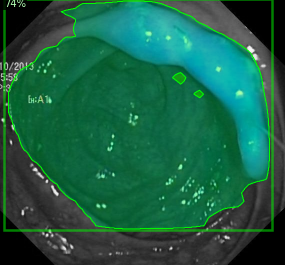

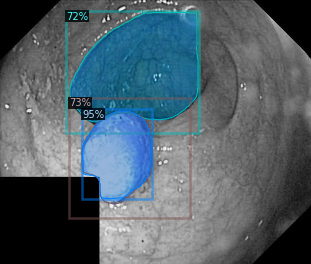

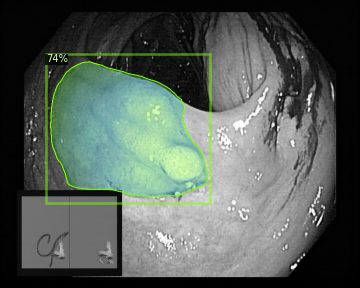

In [29]:
from tqdm.autonotebook import tqdm

# cfg already contains everything we've set previously. Now we changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
cfg.DATASETS.TEST = ('polyp_train',)
predictor = DefaultPredictor(cfg)

from detectron2.utils.visualizer import ColorMode

dataset_dicts = polyp_dataset
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=polyp_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv_img = out.get_image()[:, :, ::-1]
#     cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(cv_img))